In [1]:
import os
import time
import copy
import numpy as n
import numpy.lib.recfunctions as rfn
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import torch
from torch import nn
import umap
import matplotlib
from sklearn.decomposition import PCA

In [2]:
def load_data(data_root, dlc_dir, ann_dir, verbose=False):
    
    dlc_path = os.path.join(data_root, dlc_dir)
    ann_path = os.path.join(data_root, ann_dir)
    all_data = {}
    if verbose: print("Loading files: ")
    for f_name in os.listdir(dlc_path):
        if f_name[-3:] != 'npy':
            continue

        dlc_file=os.path.join(dlc_path, f_name)
        ann_file=os.path.join(ann_path, 'Annotated_' + f_name)
        if verbose: print("\t" + f_name + "\n\tAnnotated_" + f_name)
        data_dlc = n.load(dlc_file)
        data_ann = n.load(ann_file)
        labels = data_dlc[0]
        dtype = [('t', n.int), ('ann', 'U30')]
        i = 0
        for label in data_dlc[0]:
            i += 1
            coord = 'x' if i % 2 == 0 else 'y'
            dtype += [(label + '_' + coord , n.float32 )]

        data_concat = n.concatenate((data_ann, data_dlc[1:]),axis=1)
        data = n.array(n.zeros(data_concat.shape[0]), dtype = dtype)
        for i in range(data_concat.shape[1]):
            data[dtype[i][0]] = data_concat[:, i]
        all_data[f_name[:-4]] = data
    return all_data
def extract_data(trial):
    num_markers = int((len(trial.dtype.names)-2)/2)

    all_labels = trial.dtype.names[2:]

    markers_1 = []
    markers_2 = []
    positions_1 = n.zeros((trial.shape[0], int(num_markers/2), 2))
    positions_2 = n.zeros((trial.shape[0], int(num_markers/2), 2))

    for i in range(num_markers):
        label = all_labels[i*2][:-2]
        label_x = label+'_x'
        label_y = label+'_y'
        if label[-1] == '1':
            markers_1.append(label)
            idx = len(markers_1)-1
            positions_1[:,idx, 0] = trial[label_x]
            positions_1[:,idx, 1] = trial[label_y]
        else:
            markers_2.append(label)
            idx = len(markers_2)-1
            positions_2[:,idx,0] = trial[label_x]
            positions_2[:,idx,1] = trial[label_y]
    return n.array(markers_1), n.array(markers_2), positions_1, positions_2

In [3]:
# LOAD RAW DATA
data_root = '/mnt/d/Ali/Google Drive/SWC/Experimental Neuroscience/social and affective systems/rat_social_beh'
dlc_dir = 'postprocessedXYCoordinates'
ann_dir = 'manualannotations'
dlc_path = os.path.join(data_root, dlc_dir)
ann_path = os.path.join(data_root, ann_dir)

all_data = load_data(data_root, dlc_dir, ann_dir)

In [5]:
# PROCESS RAW DATA
# 45: since the first n_window/2 frames lack latents in the VAME output
trial = all_data['Female1'][11045:25000]
mark_1, mark_2, pos_1, pos_2 = extract_data(trial)
unique_labels = n.unique(trial['ann'])
label_map = {}; i=0
for u in unique_labels: label_map[u] = i; i+=1
labels = n.array([label_map[trial['ann'][i]] for i in range((pos_1.shape[0]))])

In [6]:
# LOAD VAME DATA
path = '/mnt/d/SWC/EN/both-rats-Nov25-2020/'

beh = {}
for file in os.listdir(os.path.join(path, 'behavior_quantification')):
    beh[file[:-4]] = n.load(os.path.join(path, 'behavior_quantification',file))
k_means_labels = n.load(os.path.join(path, '15_km_label_Female1.npy'))
latent_vectors = n.load(os.path.join(path, 'latent_vector_Female1.npy'))


In [11]:
# PCA EMBEDDINGS 
pca = PCA(n_components=10)
pca_embed = pca.fit(latent_vectors).transform(latent_vectors)

Text(0.5, 1.0, 'PCA Explained Variance')

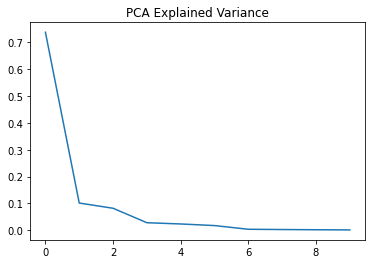

In [14]:
plt.plot(pca.explained_variance_ratio_)
plt.title("PCA Explained Variance")

In [15]:
# UMAP EMBEDDINGS
reducer = umap.UMAP(random_state=42)
reducer.fit(latent_vectors)
umap_embed = reducer.transform(latent_vectors)
assert(n.all(umap_embed == reducer.embedding_))

Text(0.5, 1.0, 'UMAP Embeddings of Latent Space Clusters')

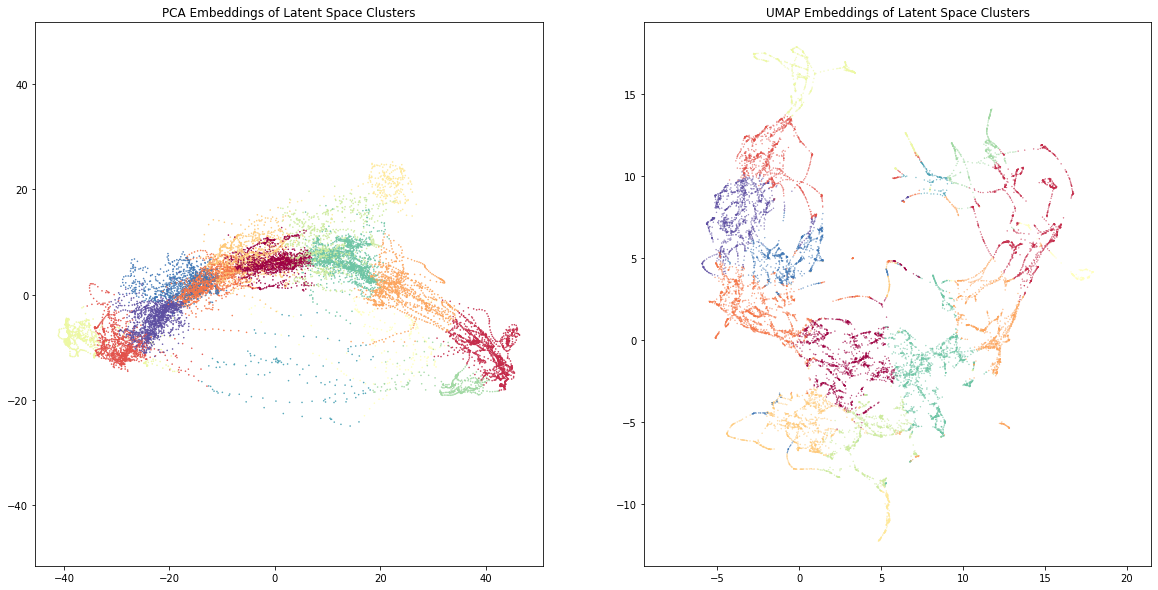

In [16]:
fig, axs = plt.subplots(1,2, figsize=(20,10))
axs[0].scatter(pca_embed[:,0], pca_embed[:,1],s=0.3,cmap='Spectral', c=k_means_labels)
axs[0].set_title("PCA Embeddings of Latent Space Clusters")
axs[0].set_aspect('equal', 'datalim')
axs[1].scatter(umap_embed[:, 0], umap_embed[:, 1], c=k_means_labels, cmap='Spectral', s=0.1)
axs[1].set_aspect('equal', 'datalim')
axs[1].set_title("UMAP Embeddings of Latent Space Clusters")

In [35]:
n.unique(labels)

array([0, 1, 2, 3, 4, 5, 6, 7])

In [36]:
unique_labels

array(['Approach', 'Following', 'broadly-Social', 'conspecific-contact',
       'head-to-head', 'head-to-tail', 'nan', 'no-contact'], dtype='<U30')

In [39]:
n.arange(n.max(labels)+1)

array([0, 1, 2, 3, 4, 5, 6, 7])

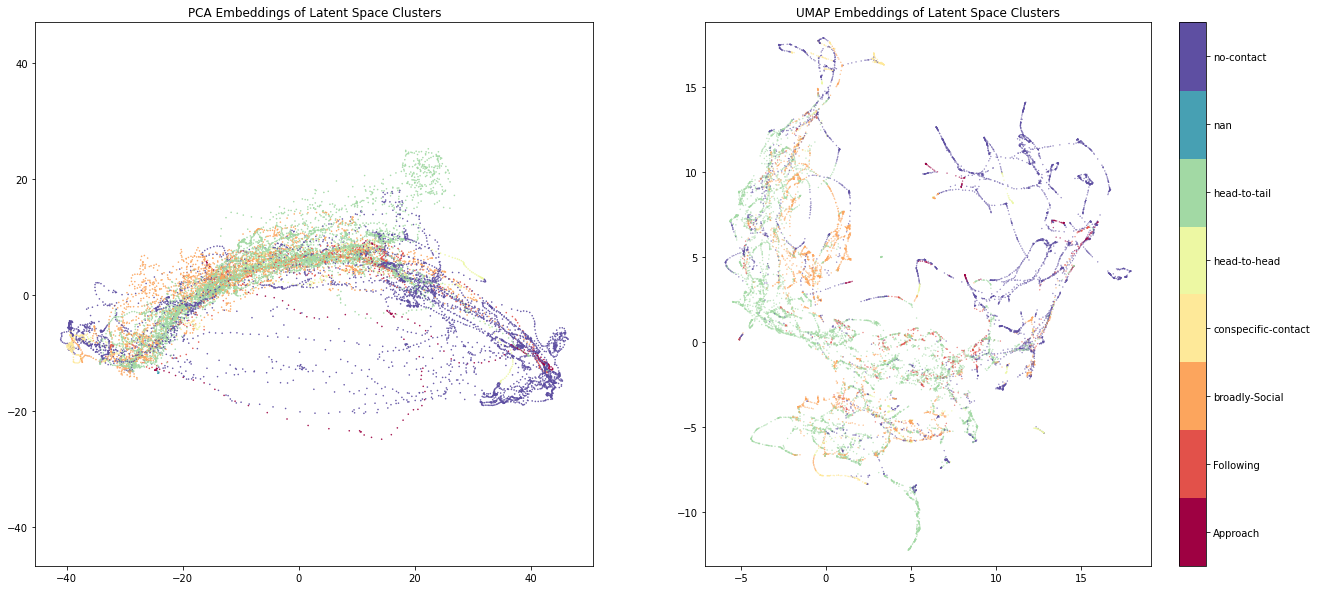

In [44]:
# Plot with annotation color labels - not good
fig, axs = plt.subplots(1,2, figsize=(22,10))
scatter = axs[0].scatter(pca_embed[:,0], pca_embed[:,1],s=0.3, c=labels, cmap='Spectral')
axs[0].set_title("PCA Embeddings of Latent Space Clusters")
axs[0].set_aspect('equal', 'datalim')
axs[1].scatter(umap_embed[:, 0], umap_embed[:, 1], c=labels, s=0.1, cmap='Spectral')
axs[1].set_aspect('equal', 'datalim')
axs[1].set_title("UMAP Embeddings of Latent Space Clusters")
cb = plt.colorbar(scatter,boundaries=n.arange(n.max(labels)+2)-0.5)
cb.set_ticks(n.arange(n.max(labels)+1))
cb.ax.set_yticklabels(unique_labels);

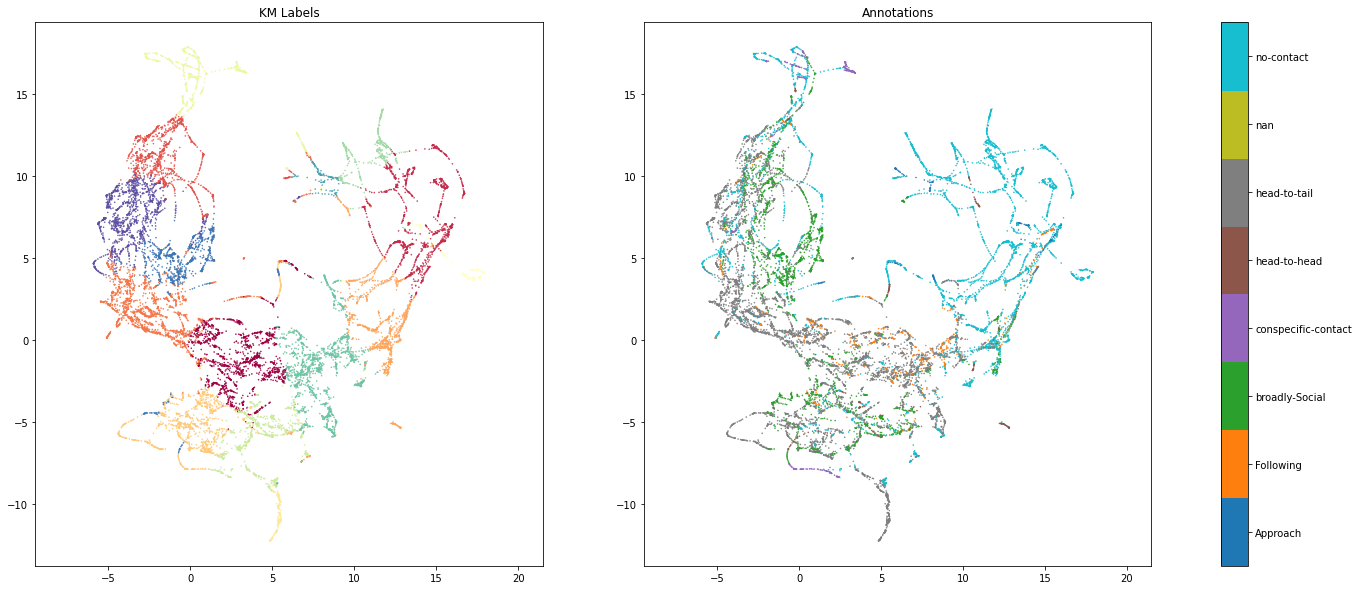

In [55]:
# Plot with annotation color labels - not good
fig, axs = plt.subplots(1,2, figsize=(25,10))
scatter1 = axs[0].scatter(umap_embed[:,0], umap_embed[:,1],s=0.3, c=k_means_labels, cmap='Spectral')
axs[0].set_title("KM Labels")
axs[0].set_aspect('equal', 'datalim')
scatter2 = axs[1].scatter(umap_embed[:, 0], umap_embed[:, 1], c=labels, s=0.3, cmap='tab10')
axs[1].set_aspect('equal', 'datalim')
axs[1].set_title("Annotations")
cb = plt.colorbar(scatter2,ax=axs.ravel().tolist(), boundaries=n.arange(n.max(labels)+2)-0.5)
cb.set_ticks(n.arange(n.max(labels)+1))
cb.ax.set_yticklabels(unique_labels);
# cb1 = plt.colorbar(scatter1,boundaries=n.arange(n.max(k_means_labels)+2)-0.5)
# cb1.set_ticks(n.arange(n.max(k_means_labels)+1))
plt.savefig('both-rats-label-comp.png', dpi=500)

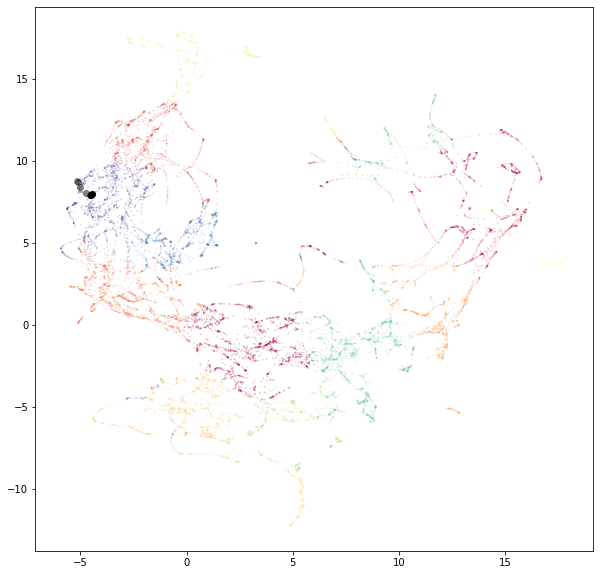

In [101]:
plt.figure(figsize=(10,10))
t_start = 1500
t_end = 2000
t_curr = 1750
window = 8
plt.scatter(umap_embed[:, 0], umap_embed[:, 1], c=k_means_labels, cmap='Spectral', s=0.2, alpha=0.3)
for i in range(window):
    plt.plot(umap_embed[t_curr-i, 0], umap_embed[t_curr-i,1],marker='o', c = 'k', alpha = 1/(i+1)**0.5)
axs[1].set_aspect('equal', 'datalim')

In [89]:
from matplotlib.animation import FuncAnimation, FFMpegWriter


In [103]:
points[0]

In [ ]:
umap_embed

In [124]:
umap_embed.shape

(13955, 2)

INIT!!
INIT!!
0
2
4
6
8
10
12
14
16
18
20
22
24
26
28
30
32
34
36
38
40
42
44
46
48
50
52
54
56
58
60
62
64
66
68
70
72
74
76
78
80
82
84
86
88
90
92
94
96
98
100
102
104
106
108
110
112
114
116
118
120
122
124
126
128
130
132
134
136
138
140
142
144
146
148
150
152
154
156
158
160
162
164
166
168
170
172
174
176
178
180
182
184
186
188
190
192
194
196
198
200
202
204
206
208
210
212
214
216
218
220
222
224
226
228
230
232
234
236
238
240
242
244
246
248
250
252
254
256
258
260
262
264
266
268
270
272
274
276
278
280
282
284
286
288
290
292
294
296
298
300
302
304
306
308
310
312
314
316
318
320
322
324
326
328
330
332
334
336
338
340
342
344
346
348
350
352
354
356
358
360
362
364
366
368
370
372
374
376
378
380
382
384
386
388
390
392
394
396
398
400
402
404
406
408
410
412
414
416
418
420
422
424
426
428
430
432
434
436
438
440
442
444
446
448
450
452
454
456
458
460
462
464
466
468
470
472
474
476
478
480
482
484
486
488
490
492
494
496
498
500
502
504
506
508
510
512
514
516
518
5

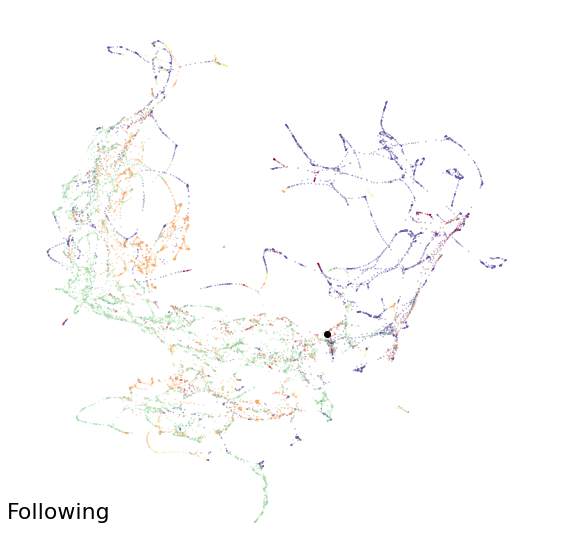

In [137]:
%%time
downsample = 2
t_start = 0
t_len = 13950
window = 10



fig,ax = plt.subplots(figsize=(10,10))
t_end = t_start+t_len
ax.axis('off')
plt.xlim(-8,21)
plt.ylim(-14,20)
points = [ax.plot([],[],c='k',marker='o', alpha = 1/(i+1)**2)[0] for i in range(window)]
points += [ax.text(-8, -12, "nan", fontsize=22)]
def init():
    print("INIT!!")
    plt.scatter(umap_embed[:, 0], umap_embed[:, 1], c=labels, cmap='Spectral', s=0.2, alpha=0.3)
    return points
def update(t_curr):
    print(t_curr)
    for i,l in enumerate(points):
        if i < window:
            l.set_data(umap_embed[t_curr-i*downsample,0], umap_embed[t_curr-i*downsample,1])
        else: 
            l.set_text(unique_labels[labels[t_curr]])
    return points
ani = FuncAnimation(fig, update, frames=n.arange(t_start,t_end,downsample),
                    init_func=init, blit=True)
    
writer = FFMpegWriter(fps=int(40/downsample), bitrate=10000)
ani.save('both-rats.mp4', writer=writer) 
# for i in range(window):
#     plt.scatter(umap_embed[t_curr-i, 0], umap_embed[t_curr-i,1], c = 'k', alpha = 1/(i+1))
# axs[1].set_aspect('equal', 'datalim')

250 at 00:20 am
950 at 00:25 am
3250 at 0:37

-> 700 frames / 5 minutes;
at 20 fps, 35 seconds/5 minutes; 
video is ~12 minutes -> 2 hours

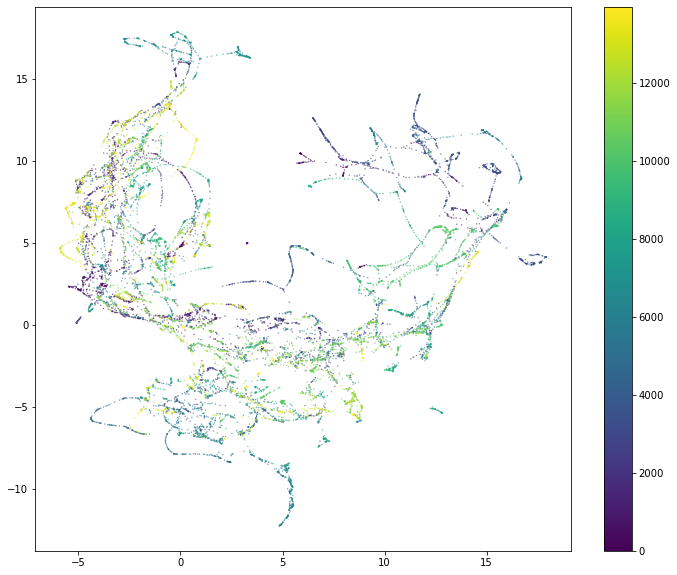

In [46]:
plt.figure(figsize=(12,10))
plt.scatter(umap_embed[:, 0], umap_embed[:, 1], c=range(umap_embed.shape[0]), s=0.1)
plt.colorbar()
axs[1].set_aspect('equal', 'datalim')